In [1]:
# Do not change the path of this notebook (do not use %cd)
from PIL import Image

print("GTA5 dataset")
img = Image.open('/home/mateusw/repos/domain_adaptation_semantic_segmentation/data/GTA5/labels/00001.png')
print(img.mode)

print("Cityscapes dataset")
img = Image.open('data/Cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_000164_gtFine_labelTrainIds.png')
print(img.mode)

GTA5 dataset
P
Cityscapes dataset
L


# Prepare Enviroment

In [2]:

#!git clone https://github.com/MateusWiteck/domain_adaptation_semantic_segmentation.git


In [3]:
%run train.py

In [4]:
# Download Citiescapes Dataset:
#!pip install -q gdown
#!gdown --id 1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2 --output Cityscapes.zip
#!unzip Cityscapes.zip -d domain_adaptation_semantic_segmentation/data/


In [5]:
# Download GTA Dataset:
#!pip install -q gdown
#!gdown --id 1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23 --output GTA5.zip
#!unzip GTA5.zip -d domain_adaptation_semantic_segmentation/data/


# Dataset and Dataloader

Here we should:
- Convert the GTA5 labels to the same format of the Cityscapes dataset (https://github.com/sarrrrry/PyTorchDL_GTA5/blob/master/pytorchdl_gta5/labels.py)
- Create the Datasets class for each one
- Create the DataLoader
- Define the train test val ? division

## Cityscapes

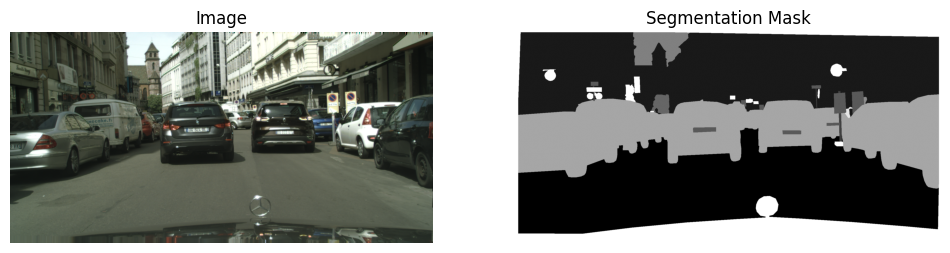

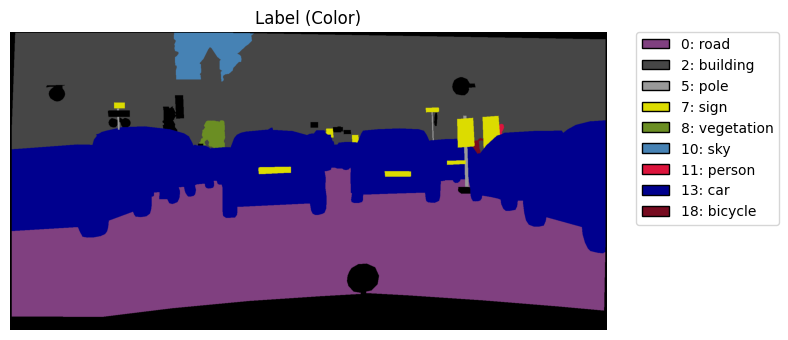

In [6]:
%run datasets/cityscapes.py


## GTA5


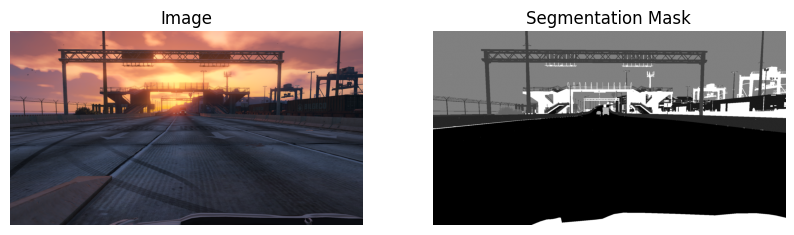

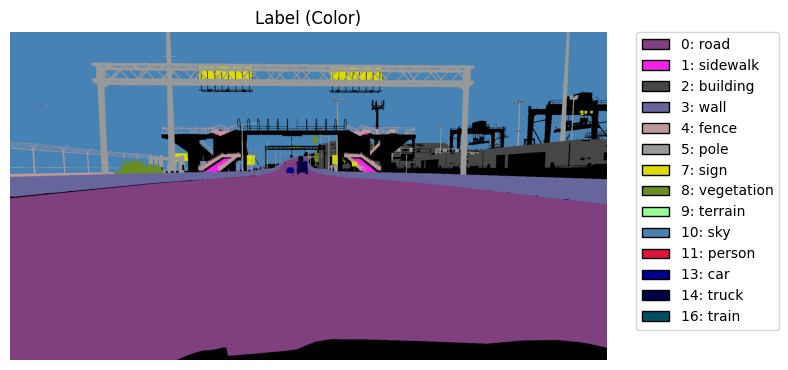

In [8]:
%run datasets/gta5.py

In [9]:
gta5_dataset = GTA5("data/GTA5/",
                    transform=None,
                    label_transform= None)


In [ ]:
#%cd domain_adaptation_semantic_segmentation/
#!git pull
#!git fetch --all
#%cd ..

# Task 2


## Classic semantic segmentation network.
For this step, you have to train a classic segmentation network (DeepLabV2 [2]) on the Cityscapes dataset. 
Dataset: Cityscapes [5]
Training epochs: 50
Training resolution (Cityscapes): 1024x512
Test resolution (Cityscapes): 1024x512
Backbone: R101 (pre-trained on ImageNet) [2]
Semantic classes: 19
Metrics: Mean Intersection over Union (mIoU) [read this to understand the metrics], latency, FLOPs, number of parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets.cityscapes import CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2


# === Hyperparameters ===
num_classes_cs = 19
batch_size_cs = 4
num_workers_cs = 4
learning_rate_cs = 2.5e-4
num_epochs_cs = 40
device_cs = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Dataset & Dataloader ===
transform_cs = transforms.ToTensor()
dataset_cs = CityScapes(
    root_dir='data/Cityscapes/Cityspaces',
    split='train',
    transform=transform_cs,
    label_transform=None
)
dataloader_cs = DataLoader(
    dataset_cs,
    batch_size=batch_size_cs,
    shuffle=True,
    num_workers=num_workers_cs,
    pin_memory=True
)

# === Model ===
model_cs = get_deeplab_v2(num_classes=num_classes_cs, pretrain=False)
model_cs = model_cs.to(device_cs)

# === Loss & Optimizer ===
criterion_cs = nn.CrossEntropyLoss(ignore_index=255)
optimizer_cs = optim.SGD(
    model_cs.optim_parameters(learning_rate_cs),
    lr=learning_rate_cs
)

# === Training Loop ===
for epoch_cs in range(num_epochs_cs):
    model_cs.train()
    total_loss_cs = 0.0

    for images_cs, labels_cs in dataloader_cs:
        images_cs = images_cs.to(device_cs)
        labels_cs = labels_cs.to(device_cs)

        preds_cs, _, _ = model_cs(images_cs)

        if preds_cs.shape[-2:] != labels_cs.shape[-2:]:
            preds_cs = nn.functional.interpolate(preds_cs, size=labels_cs.shape[-2:], mode='bilinear', align_corners=True)

        loss_cs = criterion_cs(preds_cs, labels_cs.long())
        optimizer_cs.zero_grad()
        loss_cs.backward()
        optimizer_cs.step()

        total_loss_cs += loss_cs.item()

    print(f"[Cityscapes] Epoch [{epoch_cs + 1}/{num_epochs_cs}], Loss: {total_loss_cs / len(dataloader_cs):.4f}")


AttributeError: 'ResNetMulti' object has no attribute 'multi_level'